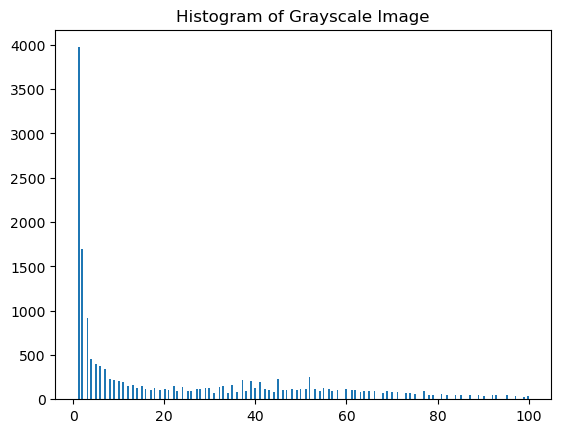

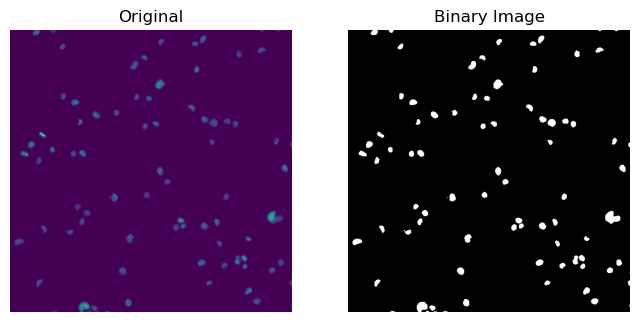

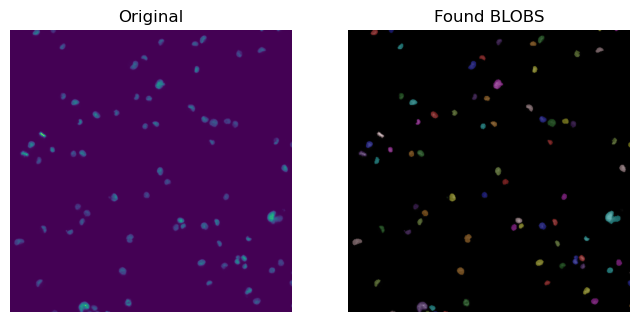

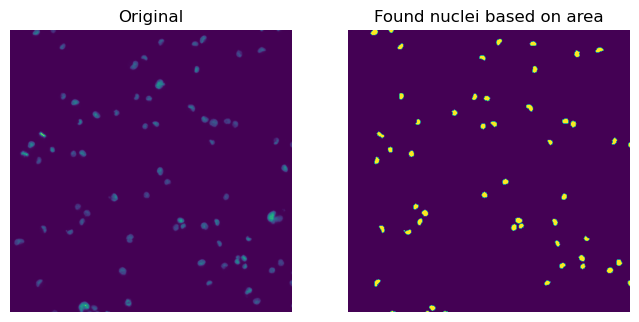

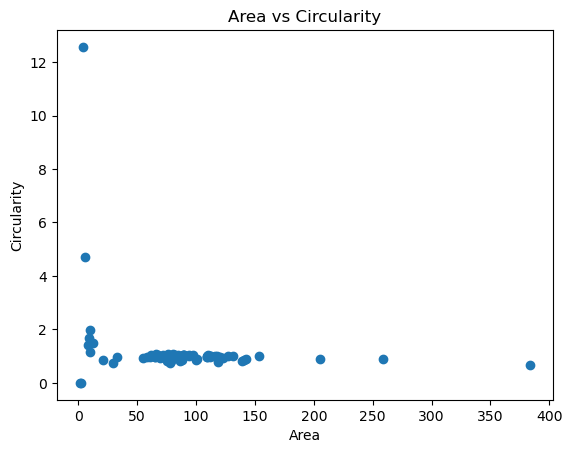

Number of well-formed nuclei: 1
Processing region 1
Processing region 2
Processing region 3
Processing region 4


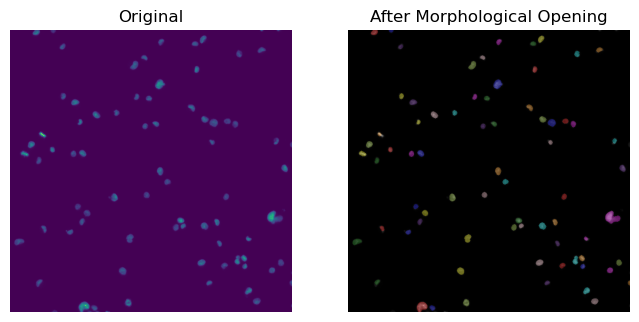

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, measure
from skimage.util import img_as_ubyte
from skimage.morphology import opening, disk
from skimage.filters import threshold_otsu
from skimage.color import label2rgb

# Function to display original and modified images side by side
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified, cmap='gray' if modified_name == 'Binary Image' else None)
    ax2.set_title(modified_name)
    ax2.axis('off')
    plt.show()

# Load and preprocess the image
img_org = io.imread('Sample G1 - COS7 cells DAPI channel.tiff')

# Slice to extract a smaller region of interest
img_small = img_org[700:1200, 900:1400]

# Convert the image to grayscale (if needed) and ensure it's in byte format
img_gray = img_as_ubyte(img_small)

# Display histogram for analysis
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
plt.title('Histogram of Grayscale Image')
plt.show()

# Apply a threshold to create a binary image
binary_image = img_gray > 20  # You may adjust the threshold value as necessary
show_comparison(img_small, binary_image, "Binary Image")

# Label connected regions in the binary image
label_img = measure.label(binary_image)

# Create a color overlay of labeled regions
image_label_overlay = label2rgb(label_img, image=img_small, bg_label=0)
show_comparison(img_small, image_label_overlay, 'Found BLOBS')

# Extract region properties
region_props = measure.regionprops(label_img)

# Calculate areas and perimeters
areas = np.array([prop.area for prop in region_props])
perimeters = np.array([prop.perimeter for prop in region_props])

# Define area filtering thresholds
min_area = 10
max_area = 100

# Create a copy of the label image for filtering based on area
label_img_filter = label_img.copy()
for region in region_props:
    if region.area > max_area or region.area < min_area:
        # Set pixels of unwanted regions to background
        for coords in region.coords:
            label_img_filter[coords[0], coords[1]] = 0

# Create a binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

# Calculate circularity for each object
shapes = [(4 * np.pi * areas[i]) / (perimeters[i] ** 2) if perimeters[i] != 0 else 0 for i in range(len(perimeters))]

# Plot areas vs circularity
plt.scatter(areas, shapes)
plt.xlabel('Area')
plt.ylabel('Circularity')
plt.title('Area vs Circularity')
plt.show()

# Define thresholds for well-formed nuclei based on circularity and area
well_formed_nuclei = [shape for shape in shapes if 10 < shape < 30]  # Adjust based on observed values
well_formed_count = len(well_formed_nuclei)
print(f"Number of well-formed nuclei: {well_formed_count}")

# Example: Large-scale testing by slicing the image into regions and processing each
height, width = img_org.shape[:2]
regions = [
    img_org[0:height//2, 0:width//2],   # Top-left
    img_org[0:height//2, width//2:],    # Top-right
    img_org[height//2:, 0:width//2],    # Bottom-left
    img_org[height//2:, width//2:],     # Bottom-right
]

# Process each region
for idx, region in enumerate(regions):
    print(f"Processing region {idx+1}")
    # Add your processing logic here (thresholding, labeling, etc.)

# Handling overlap using morphological opening
selem = disk(3)  # Adjust based on image characteristics
opened_image = opening(binary_image, selem)

# Proceed with labeling and analysis after morphological operations
label_img_opened = measure.label(opened_image)
image_label_overlay_opened = label2rgb(label_img_opened, image=img_small, bg_label=0)
show_comparison(img_small, image_label_overlay_opened, 'After Morphological Opening')
